Финальный проект 2й варинт

Студент Федотов Илья

Старт потока 23.03.2023

## Задание 3. Python

### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

В файле `groups_add.csv` содержится информаться об `id` пользователя и в какую группу эксперемента он попал. Чтобы обновить данные нам потребуются файл `checks.csv` с информацией об оплатах пользователей в дни проведения эксперимента. Этот файл так же со временем может изменяться, для этого напишем функцию которая принимает сразу все датасеты объединяет, фильтрует и рассчитывает нужные метрики.


Импортируем библиотеки, пропишем ссылки воспользуемся ЯндексДиск апи для загрузки файлов.

In [108]:
import pandas as pd
import seaborn as sns
import requests
import matplotlib.pyplot as plt
from urllib.parse import urlencode

In [109]:
groups_url = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_url = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_url = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [110]:
def calculate_metrics(active_users_url: str, groups_url: str, checks_url: str, groups_add_url: str) -> pd.DataFrame:
    """
    Calculate key metrics including ARPU, ARPPU, and CR based on provided datasets.

    This function takes four url links from YandexDisk on datasets as input and performs the following steps:
    1. Combines the datasets to create a unified dataset for analysis.
    2. Calculates the Average Revenue Per User (ARPU), Average Revenue Per Paying User (ARPPU),
       and Conversion Rate (CR) metrics.

    Parameters:
    - active_users_url (str): The first dataset containing data with active students.
    - groups_url (str): The second dataset containing data with information
                           about the user's belonging to the control
                           or experimental group (A - control, B - target group)
    - checks_url (str): The third dataset containing data with students payment information.
    - groups_add_url (str): The fourth dataset containing data with aadditional information about users.

    Returns:
    A pandas DataFrame with columns:
    - 'ARPU' (float): Average Revenue Per User.
    - 'ARPPU' (float): Average Revenue Per Paying User.
    - 'CR' (float): Conversion Rate.

    Note:
    - Each dataset should have columns relevant to the required calculations.
    - Ensure that the datasets have been preprocessed and filtered as needed before passing them.
    """
    def get_ydisk_url(public_key: str) -> str:
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
        final_url = base_url + urlencode(dict(public_key=public_key))
        response = requests.get(final_url)
        download_url = response.json()['href']
        return download_url

    groups_add = pd.read_csv(get_ydisk_url(groups_add_url),
                            names=['id', 'grp'], header=0)
    groups = pd.read_csv(get_ydisk_url(groups_url), sep=';')
    active_studs = pd.read_csv(get_ydisk_url(active_studs_url),
                               names=['id'], header=0)
    checks = pd.read_csv(get_ydisk_url(checks_url), sep=';',
                         names=['id', 'rev'], header=0)

    groups_total = pd.concat([groups, groups_add])
    active_users = (active_studs.merge(checks, how='left', on='id')
                  .merge(groups_total, how='left', on='id'))
    active_users['rev'].fillna(0, inplace=True)
    active_users['payment'] = active_users['rev'] > 0

    result = (active_users.groupby('grp', as_index=False)
              .agg(paid_users=('payment', 'sum'),
                   active_users=('id', 'count'),
                   revenue=('rev', 'sum')))
    result['ARPU'] = (result['revenue'] / result['active_users']).round(2)
    result['ARPPU'] = (result['revenue'] / result['paid_users']).round(2)
    result['CR'] = ((result['paid_users'] / result['active_users']) * 100).round(2)
    result['revenue'] = result['revenue'].round(2)
    return result

In [111]:
metrics = calculate_metrics(active_studs_url, groups_url, checks_url, groups_add_url)

In [112]:
metrics

,grp,paid_users,active_users,revenue,ARPU,ARPPU,CR
0,A,78,1538,72820.0,47.35,933.59,5.07
1,B,314,6803,394974.0,58.06,1257.88,4.62


### Задание 2

In [113]:
def plot_metrics(data: pd.DataFrame)-> None:
    """
    Plot metrics using data from a DataFrame.

    This function takes a DataFrame containing metrics data and plots the metrics using
    seaborn barplots. The DataFrame should have a 'grp' column representing different groups
    and other columns with metrics values to be plotted.

    Parameters:
    - data (pd.DataFrame): A DataFrame containing metrics data.

    Returns:
    None

    Example usage:
    plot_metrics(metrics_data)
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    plt.subplots_adjust(wspace=0.3, hspace=0.35)
    sns.set_palette("Set2")
    for ax, col in zip(axes.flatten(), metrics.columns[1:]):
        sns.barplot(data=metrics, x='grp', y=col, ax=ax)
        if col in ('active_users', 'paid_users'):
            ax.set_title(f"Number of {col}")
        else:
            ax.set_title(col)
        ax.set_ylabel("")
        ax.set_xlabel('groups')
    plt.show()

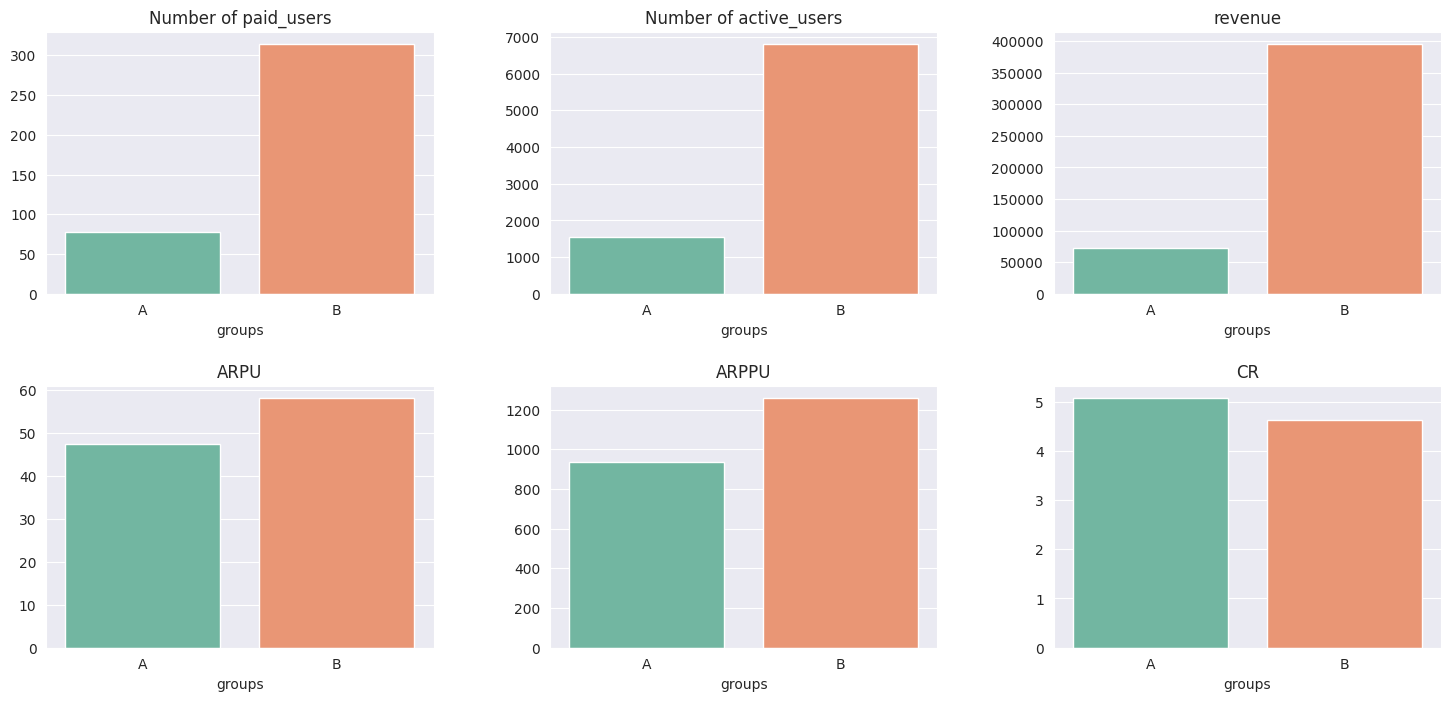

In [114]:
plot_metrics(metrics)